In [331]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

html = requests.get("https://www.rockmaraton.hu/")
soup = BeautifulSoup(html.text, "html.parser")
sections = soup.find_all("div", {"class":"container"})

sections = sections[1:4]
current_year = 2024

In [332]:
#for line in str(sections[0].contents[3]).split("\n"):
#    try:
#        print(re.search(r'time\">(.*?)</div>', line).group(1))
#    except:
#        continue

In [333]:
longest_list_length = 0
artist_text = " Előadó"
time_text = " Kezdés"

stages = dict()
for section in sections:
    stage_name = re.search(r'<h3>(.*?)</h3>', str(section.contents[1])).group(1)
    stages[stage_name] = dict()
    day_counter = 1
    item = str(section.contents[3])
    item_list = item.split("\n")
    current_day = ""

    for item_index in range(len(item_list)):
        if ("07") in item_list[item_index]:
            current_day = "07." + f"{10 + day_counter} " + re.search(r'day\">(.*?)</span', item_list[item_index]).group(1)
            day_counter += 1
            stages[stage_name][current_day + artist_text] = []
            stages[stage_name][current_day + time_text] = []
            continue
        else:
            if "img" in item_list[item_index]:
                stages[stage_name][current_day + artist_text].append(re.search(r'alt=\"(.*?)\" src=', item_list[item_index]).group(1))
                if (longest_list_length < len(stages[stage_name][current_day + artist_text])):
                    longest_list_length = len(stages[stage_name][current_day + artist_text])
            try:
                stages[stage_name][current_day + time_text].append(re.search(r'time\">(.*?)</div>', item_list[item_index]).group(1))
            except:
                continue

In [334]:
stages_good = dict()
for big_key in stages.keys():
    #print(stages_good)
    for small_key in stages[big_key].keys():
        stages_good[small_key] = stages_good.get(small_key, dict())
        stages_good[small_key][big_key] = stages_good[small_key].get(big_key, [])
        stages_good[small_key][big_key] += (stages[big_key][small_key])

In [335]:
dfs_by_day = {key.split(" ")[0]: pd.concat(
    [pd.DataFrame(dict([(k + artist_text,pd.Series(v)) for k,v in stages_good[key].items()])), pd.DataFrame(dict([(k + time_text,pd.Series(v)) for k,v in stages_good[key.replace("Előadó", "Kezdés")].items()]))], axis=1)
    .fillna(np.nan)
    for key in stages_good.keys() if "Előadó" in key}

In [336]:
#All in one, not separated by days
"""
test_tuples = []
for mondth_and_date in dfs_by_day.keys():
    column_shift = int(len(dfs_by_day[mondth_and_date].columns) / 2)
    for column_index in range(column_shift): # which columns to work with
        for artist_index in range(len(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index]])):
            if(type(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index + column_shift]][artist_index]) == float):
                break
            hour_and_minutes = dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index + column_shift]][artist_index].split(":")
            day_delta = 0
            if (int(hour_and_minutes[0]) < 5):
                day_delta = 1
            if (artist_index == 0):
                test_tuples.append((                                                                                        # START TIME
                    dt.datetime(                                                                                            # exact date of concert
                        current_year,                                                                                       # year
                        int(mondth_and_date.split(".")[0]),                                                                 # month
                        int(mondth_and_date.split(".")[1]),                                                                 # day
                        int(hour_and_minutes[0]),                                                                           # hour
                        int(hour_and_minutes[1]))                                                                           # minute
                        + dt.timedelta(days=(day_delta)),                                                                   # add delta day
                                                                                                                            # FINISH TIME
                    dt.datetime(                                                                                            # exact date of concert
                        current_year,                                                                                       # year
                        int(mondth_and_date.split(".")[0]),                                                                 # month
                        int(mondth_and_date.split(".")[1]),                                                                 # day
                        int(hour_and_minutes[0]),                                                                           # hour
                        int(hour_and_minutes[1]))                                                                           # minute
                        + dt.timedelta(hours=(2 + day_delta * 24)),                                                         # add 2 hours to the end
                    f"{dfs_by_day[mondth_and_date].columns[column_index]}",                                                 # stage
                    "{}".format(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index]][artist_index].replace(' ','\n'))))     # artist
            else:
                test_tuples.append((                                                                                        # START TIME
                    dt.datetime(                                                                                            # exact date of concert
                        current_year,                                                                                       # year
                        int(mondth_and_date.split(".")[0]),                                                                 # month
                        int(mondth_and_date.split(".")[1]),                                                                 # day
                        int(hour_and_minutes[0]),                                                                           # hour
                        int(hour_and_minutes[1]))                                                                           # minute
                        + dt.timedelta(days=(day_delta)),                                                                   # add delta day
                    test_tuples[len(test_tuples) - 1][0] - dt.timedelta(minutes=(20)),                                      # FINISH TIME - the previous concert's start time with a 20 minutes break                                                                      
                    f"{dfs_by_day[mondth_and_date].columns[column_index]}",                                                 # stage
                    "{}".format(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index]][artist_index].replace(' ','\n'))))     # artist
"""

"""
data = test_tuples

# Create a mapping for categories and colors
categories = list(set([d[2] for d in data]))
cats = {category: i+1 for i, category in enumerate(categories)}
colormapping = {category: f"C{i}" for i, category in enumerate(categories)}

verts = []
colors = []
for d in data:
    v = [(mdates.date2num(d[0]), cats[d[2]] - .4),
         (mdates.date2num(d[0]), cats[d[2]] + .4),
         (mdates.date2num(d[1]), cats[d[2]] + .4),
         (mdates.date2num(d[1]), cats[d[2]] - .4),
         (mdates.date2num(d[0]), cats[d[2]] - .4)]
    verts.append(v)
    colors.append(colormapping[d[2]])

bars = PolyCollection(verts, facecolors=colors)

fig, ax = plt.subplots()
fig.set_size_inches(100, 20)
ax.add_collection(bars)
ax.autoscale()

loc = mdates.HourLocator(interval=1)
ax.xaxis.set_major_locator(loc)
#ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

ax.set_yticks(list(cats.values()))
ax.set_yticklabels(list(cats.keys()))

for d in data:
    x_pos = mdates.date2num(d[0]) + (mdates.date2num(d[1]) - mdates.date2num(d[0])) / 2
    y_pos = cats[d[2]]
    label = f"{d[3]}"
    ax.text(x_pos, y_pos, label, ha='center', va='center', color='white', fontsize=36)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""

'\ndata = test_tuples\n\n# Create a mapping for categories and colors\ncategories = list(set([d[2] for d in data]))\ncats = {category: i+1 for i, category in enumerate(categories)}\ncolormapping = {category: f"C{i}" for i, category in enumerate(categories)}\n\nverts = []\ncolors = []\nfor d in data:\n    v = [(mdates.date2num(d[0]), cats[d[2]] - .4),\n         (mdates.date2num(d[0]), cats[d[2]] + .4),\n         (mdates.date2num(d[1]), cats[d[2]] + .4),\n         (mdates.date2num(d[1]), cats[d[2]] - .4),\n         (mdates.date2num(d[0]), cats[d[2]] - .4)]\n    verts.append(v)\n    colors.append(colormapping[d[2]])\n\nbars = PolyCollection(verts, facecolors=colors)\n\nfig, ax = plt.subplots()\nfig.set_size_inches(100, 20)\nax.add_collection(bars)\nax.autoscale()\n\nloc = mdates.HourLocator(interval=1)\nax.xaxis.set_major_locator(loc)\n#ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))\n#ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d %H:%M\'))\nax.xaxis.set_major_f

In [337]:
test_tuples = [[] for key in dfs_by_day.keys()]
hours_collection = [set() for key in dfs_by_day.keys()]
initial_day = 11
for mondth_and_date in dfs_by_day.keys():
    #print(mondth_and_date)
    column_shift = int(len(dfs_by_day[mondth_and_date].columns) / 2)
    for column_index in range(column_shift): # which columns to work with
        for artist_index in range(len(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index]])):
            #print(artist_index)
            if(type(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index + column_shift]][artist_index]) == float):
                break
            hour_and_minutes = dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index + column_shift]][artist_index].split(":")
            day_delta = 0
            test_tuples_index = int(mondth_and_date.split(".")[1]) - initial_day
            if (int(hour_and_minutes[0]) < 5):
                day_delta = 1
            if (artist_index == 0):
                test_tuples[test_tuples_index].append((                                      # START TIME
                    dt.datetime(                                                                                            # exact date of concert
                        current_year,                                                                                       # year
                        int(mondth_and_date.split(".")[0]),                                                                 # month
                        int(mondth_and_date.split(".")[1]),                                                                 # day
                        int(hour_and_minutes[0]),                                                                           # hour
                        int(hour_and_minutes[1]))                                                                           # minute
                        + dt.timedelta(days=(day_delta)),                                                                   # add delta day
                                                                                                                            # FINISH TIME
                    dt.datetime(                                                                                            # exact date of concert
                        current_year,                                                                                       # year
                        int(mondth_and_date.split(".")[0]),                                                                 # month
                        int(mondth_and_date.split(".")[1]),                                                                 # day
                        int(hour_and_minutes[0]),                                                                           # hour
                        int(hour_and_minutes[1]))                                                                           # minute
                        + dt.timedelta(hours=(2 + day_delta * 24)),                                                         # add 2 hours to the end
                    f"{dfs_by_day[mondth_and_date].columns[column_index]}",                                                 # stage
                    "{}".format(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index]][artist_index].replace(' ','\n'))))     # artist
                
                                                
                hours_collection[test_tuples_index].add(                                                                    # hours for the plot
                    dt.datetime(                                                                   
                        current_year,                                                              
                        int(mondth_and_date.split(".")[0]),                                        
                        int(mondth_and_date.split(".")[1]),                                        
                        int(hour_and_minutes[0]),                                                  
                        0)                                                                         
                        + dt.timedelta(days=(day_delta)))    
                hours_collection[test_tuples_index].add(       
                    dt.datetime(                                                                           
                        current_year,                                                                      
                        int(mondth_and_date.split(".")[0]),                                                
                        int(mondth_and_date.split(".")[1]),                                                
                        int(hour_and_minutes[0]),                                                          
                        0)                                                                                 
                        + dt.timedelta(hours=(2 + day_delta * 24)))
                
            else:
                test_tuples[test_tuples_index].append((                                                                     # START TIME
                    dt.datetime(                                                                                            # exact date of concert
                        current_year,                                                                                       # year
                        int(mondth_and_date.split(".")[0]),                                                                 # month
                        int(mondth_and_date.split(".")[1]),                                                                 # day
                        int(hour_and_minutes[0]),                                                                           # hour
                        int(hour_and_minutes[1]))                                                                           # minute
                        + dt.timedelta(days=(day_delta)),                                                                   # add delta day
                    test_tuples[test_tuples_index][len(test_tuples[test_tuples_index]) - 1][0] - dt.timedelta(minutes=(5)), # FINISH TIME - the previous concert's start time with a 20 minutes break                                                                      
                    f"{dfs_by_day[mondth_and_date].columns[column_index]}",                                                 # stage
                    "{}".format(dfs_by_day[mondth_and_date][dfs_by_day[mondth_and_date].columns[column_index]][artist_index].replace(' ','\n'))))     # artist
                
                hours_collection[test_tuples_index].add(                                                    
                    dt.datetime(                                                                                           
                        current_year,                                                                                      
                        int(mondth_and_date.split(".")[0]),                                                                
                        int(mondth_and_date.split(".")[1]),                                                                
                        int(hour_and_minutes[0]),                                                                          
                        0)                                                                                                 
                        + dt.timedelta(days=(day_delta))),
                hours_collection[test_tuples_index].add( 
                    test_tuples[test_tuples_index][len(test_tuples[test_tuples_index]) - 1][0].replace(minute=0)) 
                hours_collection[test_tuples_index].add( 
                    test_tuples[test_tuples_index][len(test_tuples[test_tuples_index]) - 1][1].replace(minute=0))

In [338]:
for hour_list in hours_collection:
    # Determine the start and end of the range
    start_time = min(hour_list)
    end_time = max(hour_list)

    # Generate all whole hour timestamps within the range
    complete_hours = set()
    current_time = start_time
    while current_time <= end_time:
        complete_hours.add(current_time)
        current_time += dt.timedelta(hours=1)

    # Find the missing hours
    missing_hours = complete_hours - hour_list

    # Add the missing hours to the original set
    hour_list.update(missing_hours)

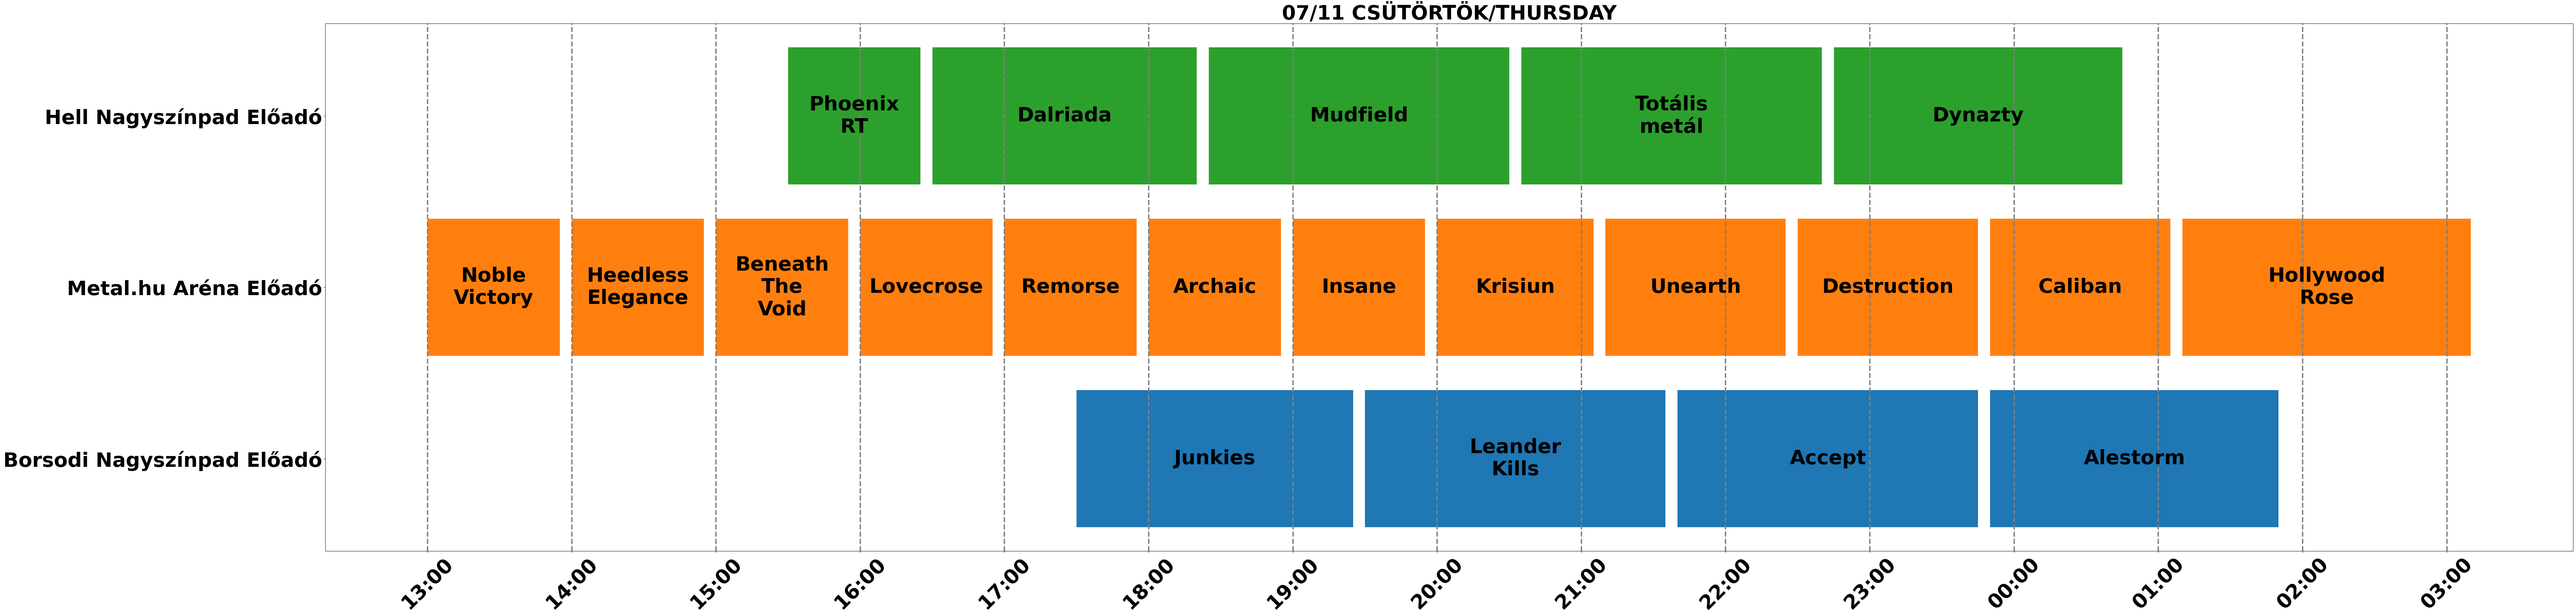

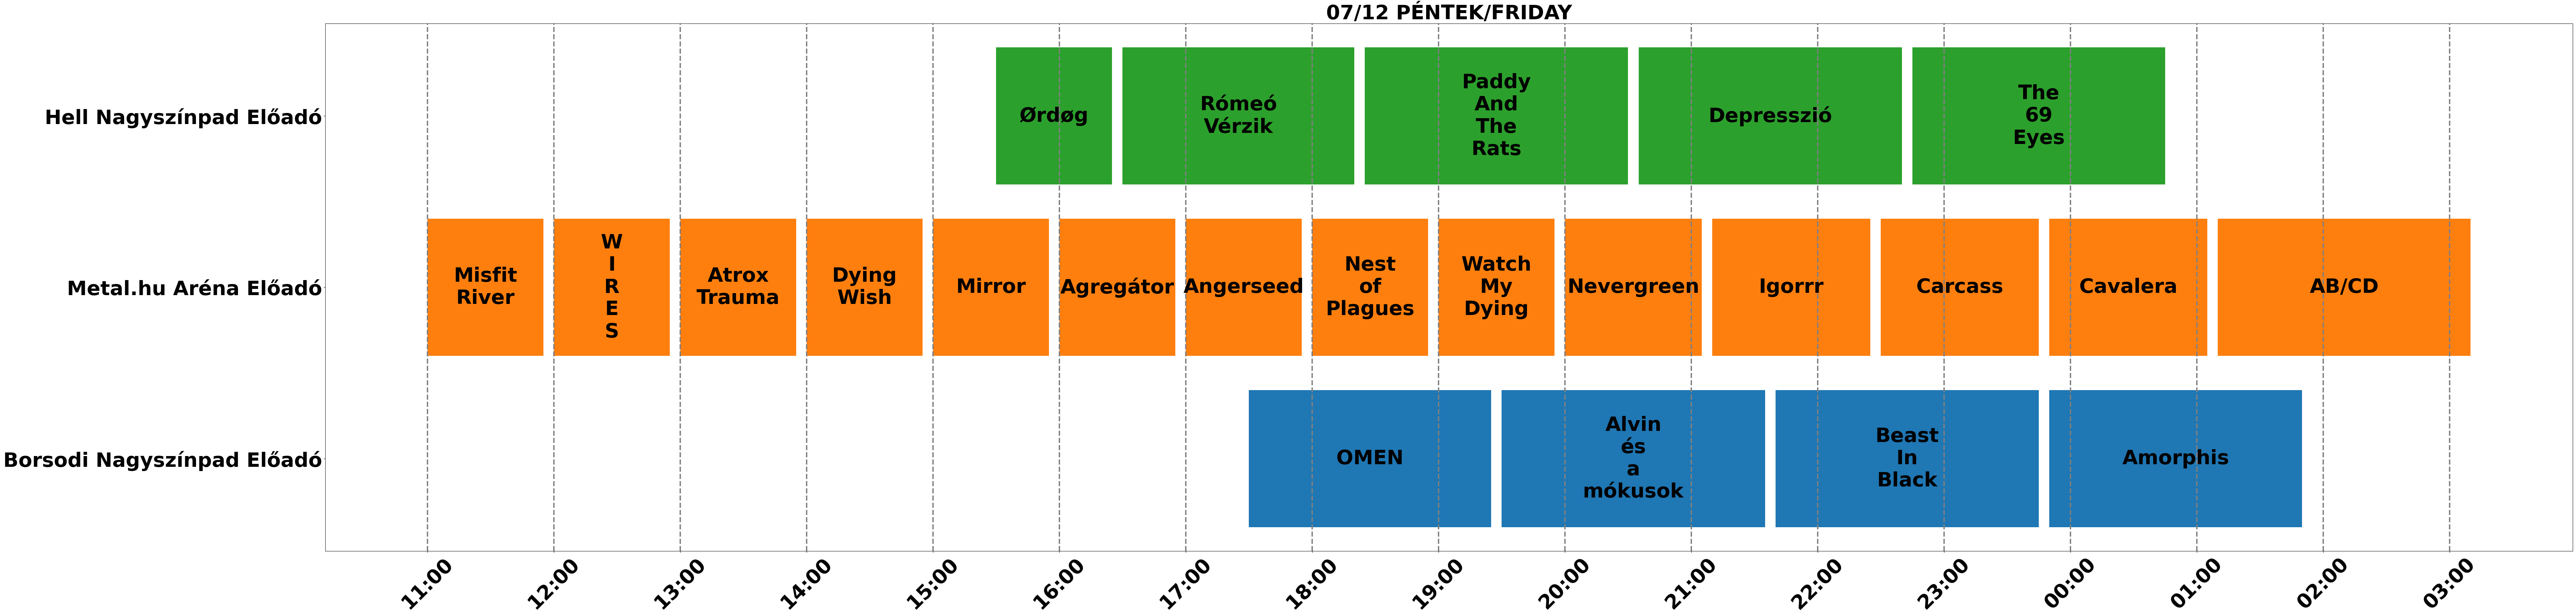

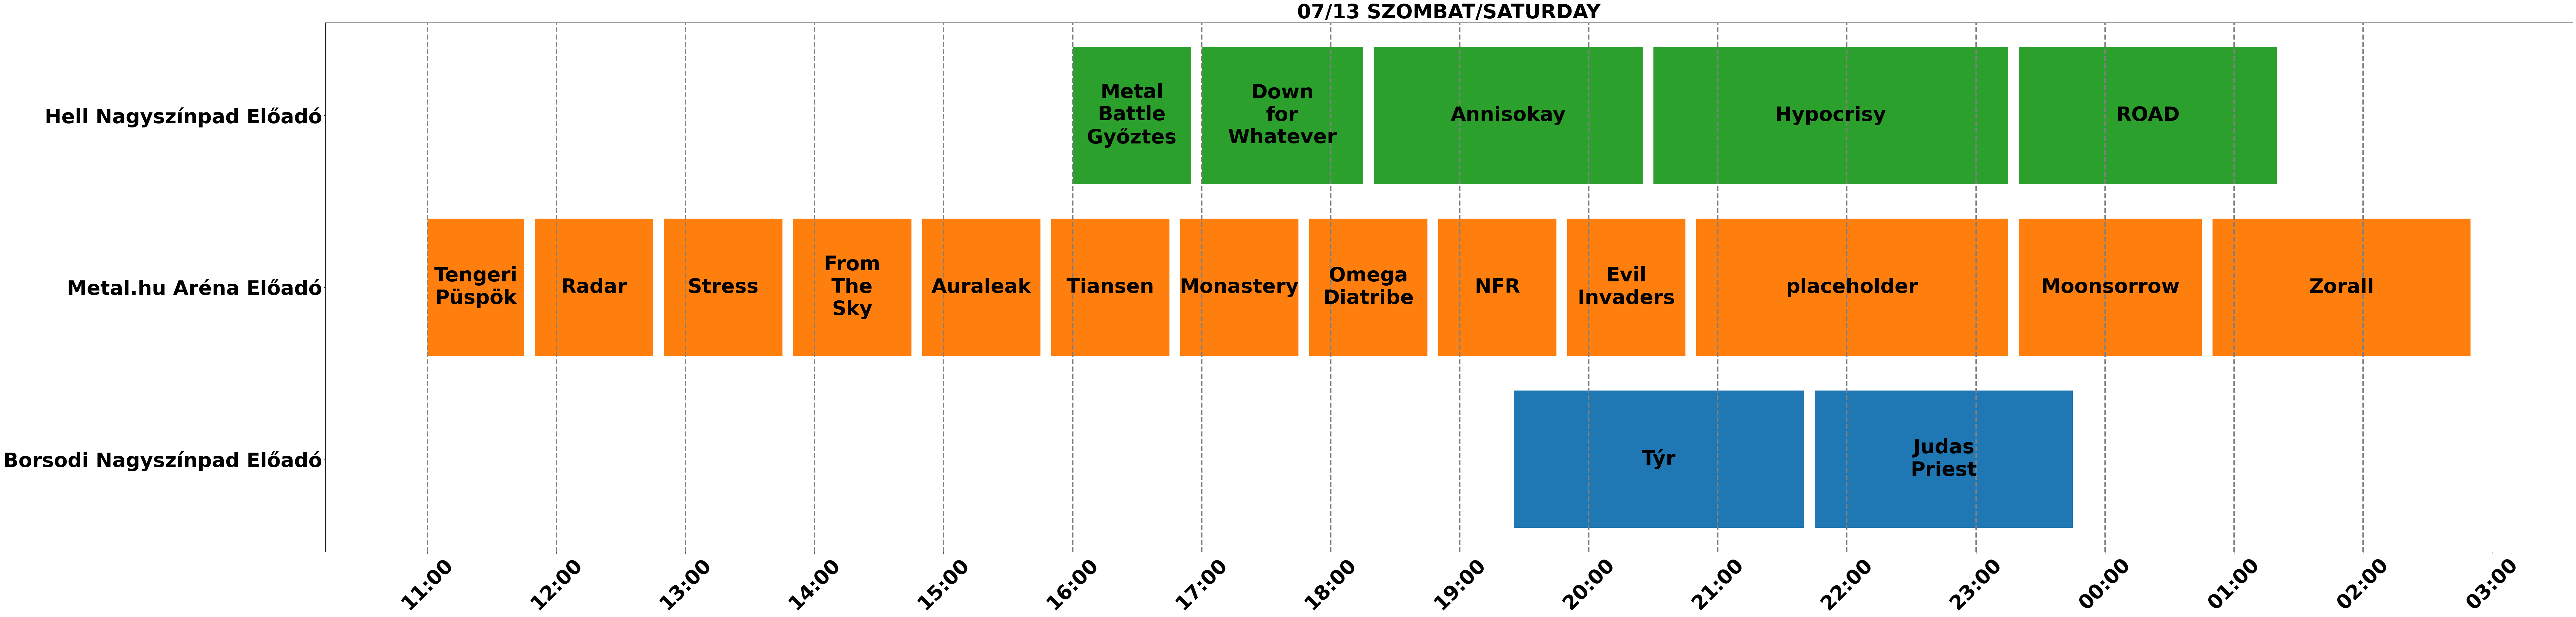

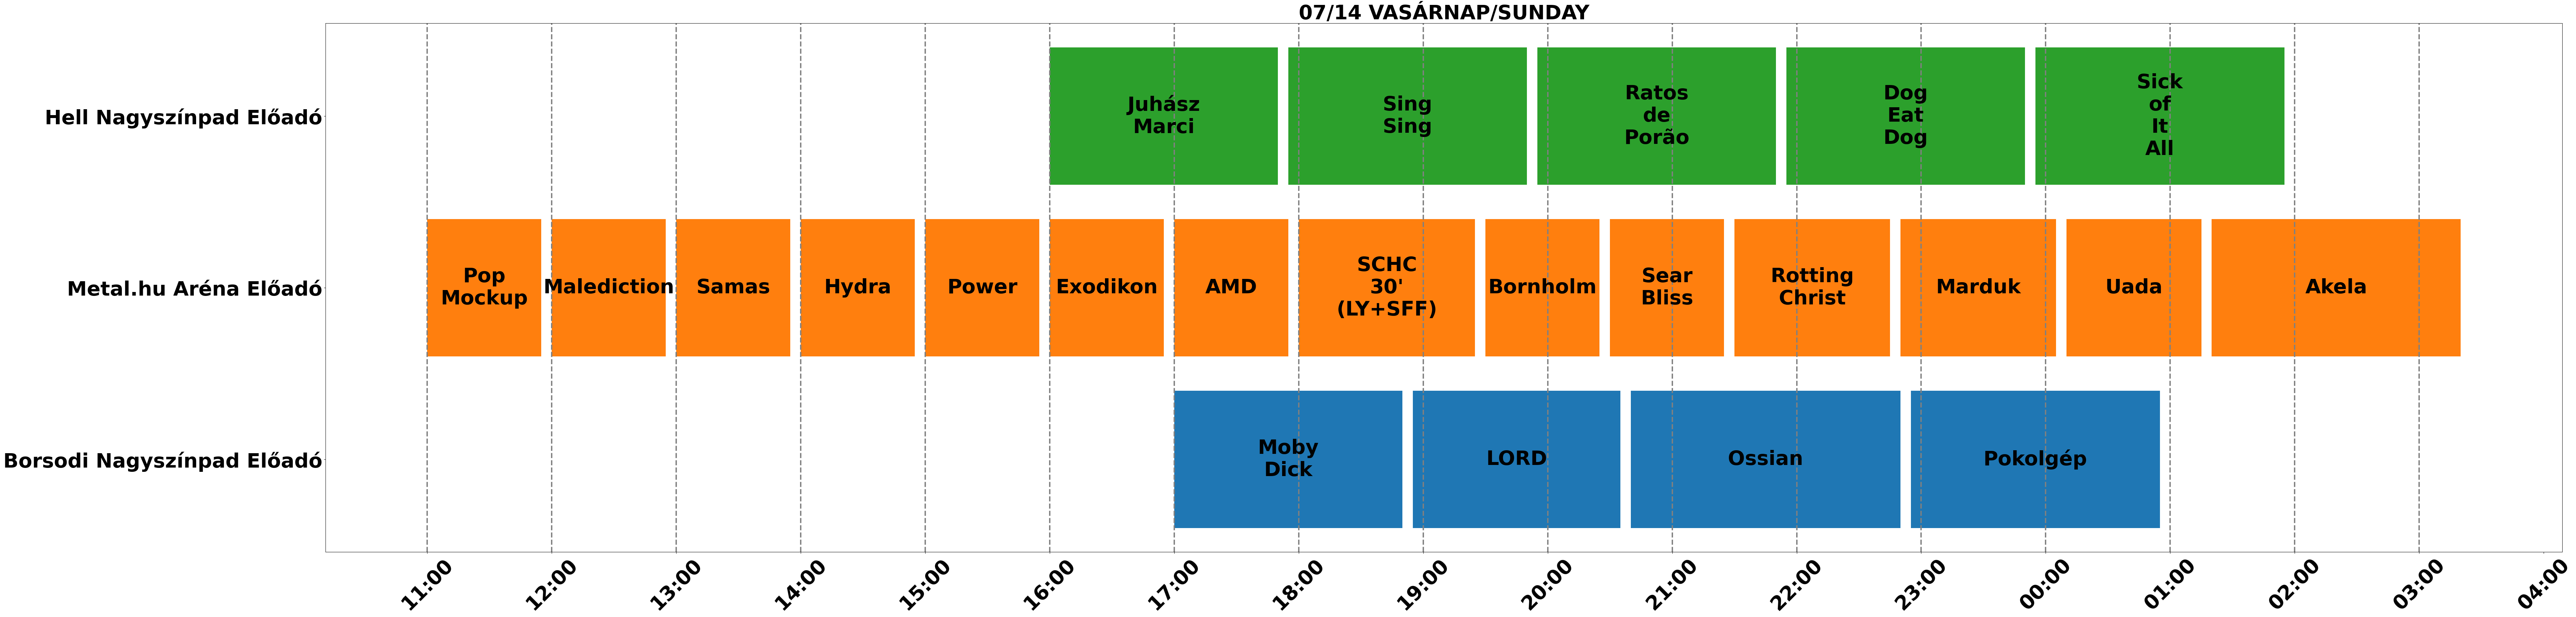

In [339]:
font_size = 44
plt.rcParams.update({'font.size': font_size, 'font.weight':'bold'})
day_number_dict={
    11: "CSÜTÖRTÖK/THURSDAY",
    12: "PÉNTEK/FRIDAY",
    13: "SZOMBAT/SATURDAY",
    14: "VASÁRNAP/SUNDAY"
}

for day_number in range(len(test_tuples)):
    data = test_tuples[day_number]

    # Create a mapping for categories and colors
    categories = list(set([d[2] for d in data]))
    cats = {category: i+1 for i, category in enumerate(categories)}
    colormapping = {category: f"C{i}" for i, category in enumerate(categories)}

    verts = []
    colors = []
    for d in data:
        v = [(mdates.date2num(d[0]), cats[d[2]] - .4),
            (mdates.date2num(d[0]), cats[d[2]] + .4),
            (mdates.date2num(d[1]), cats[d[2]] + .4),
            (mdates.date2num(d[1]), cats[d[2]] - .4),
            (mdates.date2num(d[0]), cats[d[2]] - .4)]
        verts.append(v)
        colors.append(colormapping[d[2]])

    bars = PolyCollection(verts, facecolors=colors)

    fig, ax = plt.subplots()
    fig.set_size_inches(80, 20)
    ax.add_collection(bars)
    ax.autoscale()

    for hour_and_minute in hours_collection[day_number]:
        ax.axvline(mdates.date2num(hour_and_minute), color='gray', linestyle='--', linewidth=3)

    loc = mdates.HourLocator(interval=1)
    ax.xaxis.set_major_locator(loc)
    #ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax.set_yticks(list(cats.values()))
    ax.set_yticklabels(list(cats.keys()))

    for d in data:
        x_pos = mdates.date2num(d[0]) + (mdates.date2num(d[1]) - mdates.date2num(d[0])) / 2
        y_pos = cats[d[2]]
        label = f"{d[3]}"
        ax.text(x_pos, y_pos, label, ha='center', va='center', color='black', fontsize=font_size, weight="bold")

    plt.title(f'07/{initial_day + day_number} {day_number_dict[initial_day + day_number]}', fontsize=font_size, weight="bold")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'RockMaraton Day {day_number + 1}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'RockMaraton Day {day_number + 1}.pdf', bbox_inches='tight', dpi=300)
